<a href="https://colab.research.google.com/github/Tikquuss/GflowNets_Tutorial/blob/main/1_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@author TODO



We start by defining the type of problem we want to solve. Let consider the set $\mathcal{X} \subset \mathbb{N}$, and let define on $\mathcal{X}$ the reward function $R(x) = \lambda^{- \beta \times min \{x-n*q_n(x) \text{, } n*(q_n(x)+1)-x \}} \in [0, 1]$ where $q_n(x)$ is the quotient of the Euclidean division of $x$ by $n$ ($n \in \mathbb{N}^* $), $\lambda > 1$ and $\beta > 0$  (the closer you are to a multiple of $n$, the greater the reward).  

The intuition behind this reward function is the following : a number $x$ is always surrounded by two multiples of another number $n$, $n*q_n(x) \le x < n*(q_n(x)+1)$. Among these two multiples, we choose the closest one to $x$, then we compute the distance $d = min \{x-n*q_n(x) \text{, } n*(q_n(x)+1)-x \}$ between it and this mutiple. To transform the distance into a reward, we just do $\lambda^{- \beta \times d}, \ \lambda > 1$ and $\beta > 0$.

Let $n=5$, $\lambda = 2$ and $\beta = 1$, then :
$$R(x) = \left\{
    \begin{array}{ll}
        1 & \mbox{if } x = 5k \\
        2^{-1} & \mbox{if } x=5k+1 \mbox{ or } x=5k+4=5(k+1)-1 \\
        2^{-2} & \mbox{if } x=5k+2 \mbox{ or } x=5k+3=5(k+1)-2
    \end{array} \ \ \ \ \ \ \ \ \ \ (k \in \mathbb{N})
\right.$$

We can see the distribution $R$ in the figure below for $\mathcal{X} = \{0, ....,100\}$ (*we will consider this set for the rest*).





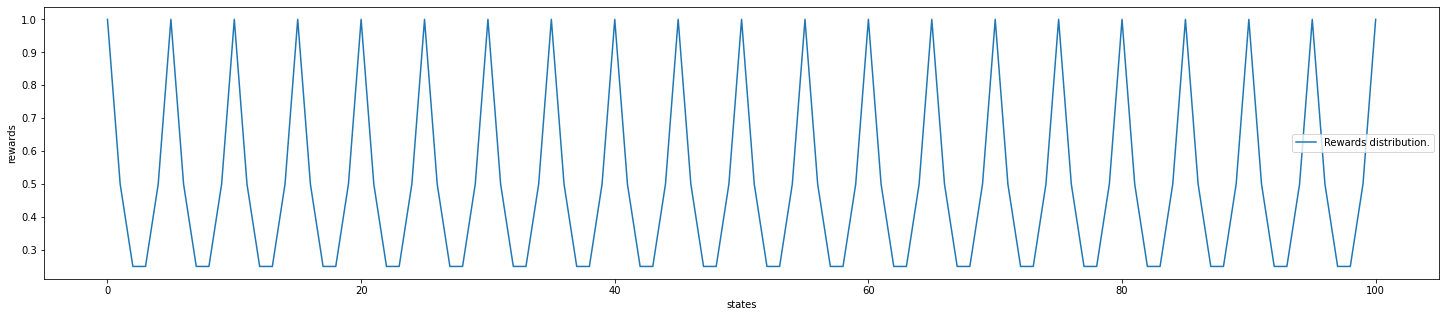

In [4]:
import matplotlib.pyplot as plt

def reward_function(x, a, lambda_ = 2, beta = 1, R_0 = 1e-6):
    q = x // a 
    return lambda_**-(beta*min(x-a*q, a*(q+1)-x)) + R_0

X = list(range(100+1))
R = [reward_function(x, a=5) for x in X]

figsize=(25,5)
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize = figsize)

ax1.plot(X, R, label="Rewards distribution.")
ax1.set(xlabel='states', ylabel='rewards')
#ax1.set_title('...')
ax1.legend()

Let $Z = \sum_{x \in \mathcal{X}}R(x) = 51$ (the canonical partition function) and let also define on $\mathcal{X}$, a probability distribution $\pi$ given by :

$$\pi(x) = \frac{R(x)}{Z} = \left\{
    \begin{array}{ll}
        \frac{1}{51} & \mbox{if } x = 5k \\
        \frac{1}{102} & \mbox{if } x=5k+1 \mbox{ or } x=5k+4=5(k+1)-1 \\
        \frac{1}{204} & \mbox{if } x=5k+2 \mbox{ or } x=5k+3=5(k+1)-2
    \end{array} \ \ \ \ \ \ \ \ \ \ (k \in \mathbb{N})
\right.$$

I call $Z$ the canonical partition function in reference to statistical physics, because our reward can be written $R(x) = e^{-{\frac{E(x)}{k_B \ T}}}$, where $E(x)$ is the Hamiltonian/energy of the microstate $x$ (of the physical system), $T$ the temperature and $k_B$ the Boltzmann constant. In this case, $\pi(x) = \frac{R(x)}{Z}$ becomes the Boltzmann factor at $x$ (probability for the system to be present in the microstate $x$).

We would like to have an algorithm that, just from the vocabulary of $\mathcal{X}$, ie $\{0, 1, ..., 9\}$, generates numbers from $\mathcal{X}$ such that the probability of an $x \in \mathcal{X}$ being generated is equal to $\pi(x)$. In other words, if the algorithm generates a list of $N$ elements, we would like to have a number $N*\pi(x)$ of each $x \in \mathcal{X}$ in the list (ie a proportion $\pi(x)$ of each $x$ in the list). *__This is called sampling from a probability distribution__*, and it is different from solving $arg\_max_{x} R(x)$ directly. The high reward or high probability (and therefore low energy) states will therefore be more generated than low reward (high energy) states.



---
If $\pi$ is explicitly known (by its mass function or repartition function), we can use methods like Inverse Transform Sampling or Acceptance-Rejection sampling (presented below). But, in many problems, $Z$, the denominator of $\pi$ is (too) hard to compute. More precisely, we must be able to sample from $\pi$ just by knowing $R$ (or a function of $R$). This situation arises in
several contexts:
* In Bayesian inference, we have $\pi(\theta | x) = \frac{\pi(\theta)p(x | \theta)}{p(x)}$ where $\pi(\theta)p(x | \theta)$ is easy to compute but $p(x)= \int_{\theta}{} \pi(\theta)p(x | \theta) d\theta$
can be very difficult or impossible to compute. So we need to be able to sample from the posterior $\pi(\theta | x)$ just by knowing $\pi(\theta)p(x | \theta)$, ie the prior $\pi(\theta)$ and the likelihood $p(x | \theta)$.
* In models from statistical physics (e.g. the Ising model), we only know $R(x) = e^{−\frac{E(x)}{k_B \ T}}$, where $E$ is the Hamiltonian, $k$ is the Boltzmann’s constant and $T$ the temperature. $Z \propto \int_{\mathcal{X}} R(x)dx$ is often difficult to compute for a system with many possible microstates (often infinite) or many parameters.

There are several methods to solve this problem. Among them we have Markov Chain Monte Carlo (MCMC) methods and GflowNets.

MCMC methods try to find a (reversible) Markov chain of transition matrix $P$ such that $\pi$ is its stationary law, i.e. $\pi P = \pi$ (note that this constraint remains valid if we multiply the two sides by a constant, $Z \pi P=Z \pi=R$ , and this is where the MCMC methods take their advantage). If such a Markov chain is found, it will be enough to simulate it up to some step $n \rightarrow \infty$ (ie simulate a random walk of infinite length on the chain, $\pi_{n+1}= \pi_n P $ with $n \rightarrow \infty$) and take the last elements obtained  (the first steps in generaly call the **burn-in** phase). Given the difficulty of finding $\pi$ and/or $P$ in practice, MCMC methods find alternatives to simulate a random walk without explicitly having $\pi$, but just $R$. In this family of algorithm we have Gibbs sampling, Metropolis-Hasting, Metropolis-adjusted Langevin (MCMC with langevin dynamics)... 

These methods are generally too expensive and generally do only local exploration (if $\pi$ has several modes separated by deserts of probabilities, these algorithms can get stuck in the same regions during the random walk). 

On the other hand, the space $\mathcal{X}$ on which the reward function is defined is very complex in many problems (and not a simple list of numbers as in the example above), for example the set of molecules, the set of sentences, the set of images ... And sampling requires very complex algorithms or models to build objects to be evaluated. In this kind of case, an algorithm that tries to successively build the objects and test them (like MCMC methods) would be very expensive. GflowNets reduce this cost because it only has to do the *build-test* process during training. Once the training is done, GflowNets can be used to build objects that follow its training reward or distribution, unlike other methods where there is no training : each time we need an object, we have to do a search (usually expensive) until we find the right one (rejection sampling) or (theoretically) up to infinity (MCMC).


GFlowNets are generative models that learn a stochastic policy that iteratively constructs the sampled object through a sequence of simpler steps, such that the probability of generating an object is proportional to its reward.

GFlowNets are interesting when the problem to solve has these properties: 

* Objects can be constructed sequentially

A molecule for example can be built by combining several atoms, a sentence can be constructed by adding each time a word after the sentence already constructed.

An example is shown in the figure below for the construction of a $3 \times 3$ binary image. We start with an empty image (initial state), then at each step, we have $9-n$ ways to choose the cell to color ($n$ represents the number of cell already colored), and 2 ways (black or white) to choose the color to assign to the chosen cell. The process continues until there are no more empty cells (final state).



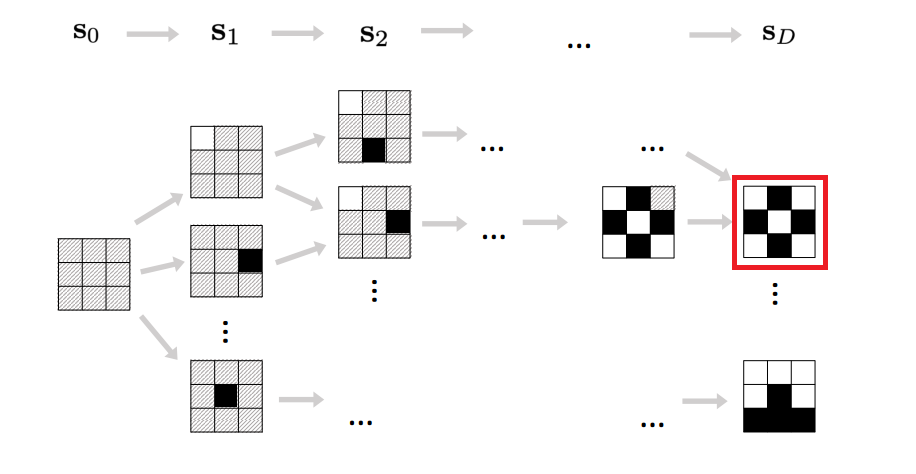

Figure from [4]





* The same object can be built (and destroyed, as GflowNets learns to build and deconstruct at the same time) in several different ways. 

In this case, we are dealing with a DAG (Directed Acyclic Graph). For example, on figure above, there are several paths that lead from the initial state to the final state in red.

The DAG can in many cases be reduced to a simple tree. For example, considering that the final sentence `[BOS] a b c [EOS]` (`[BOS]` for *Beginning Of Sentence* and `[EOS]` for *End Of Sentence*) has been constructed in an autoregressive way, it is obvious that the sentence that led to this state is `[BOS] a b c`, and the one that led to `[BOS] a b c` is `[BOS] a b`, ..., `[BOS]` (initial state). 

On the other hand, if the sentences are not constructed in an autoregressive way (for example if at each step one must first choose a position in the sentence before choosing the word to be placed at this position), one has more to do with a tree: `[BOS] a b c [EOS]` can come from `[BOS] a b c` or `[BOS] a b [EOS]` ...

* The reward function has several modes (local maximums, even though this term is not very appropriate in our case).

As an example, consider that you are looking for all multiples of a number $n$ of length less than $l > 2$. I assume here that the numbers are constructed autoregressively starting from an initial state (like `[BOS]`) and adding each time a digit between 0 and 9 at the end of the already constructed number. The process continues until a special symbol is generated (like `[EOS]`) or until the number is of length $l$. If we have instead a neural network that directly returns a number (like the generator of a GAN), then we cannot speak of a notion of flow. As a reward function, we can decide to give a score of $1$ to the multiple of $n$, and a lower and lower score when the considered number is far from a multiple of $n$. A suitable reward function in this case is the reward function introduced at the beginning of this notebook, $R(x) = \lambda^ {- \beta \times min \{x-n*q_n(x) \text{, } n*(q_n(x)+1)-x \}}$ where $q_n(x)$ is the quotient of the Euclidean division of $x$ by $n$, $\lambda > 1$ and $\beta > 0$ : the larger $\lambda$ or/and $\beta$ or/and $n$ are, the more difficult the problem becomes because of the probability desert that is created between the modes.

* The oracle (the real reward function in other words) is difficult to call. 

In the case of the multiples of $n$ above, the analytical form of the reward function is known (moreover, with a little mathematics one can find all $x$ such that $R(x) = r, \ r \in \mathbb{R}^+$).

But let's imagine the case where we have to find a molecule that kills the given virus, and that has other properties like its time of action (if the molecule kills the virus very slowly a sick person can take the drug, but die before it does its effects), that has few side effects, that is easy to manufacture... All these properties can be translated into a reward function, except that here, being given a new molecule, the specialists have to go to the laboratory, do clinical trials (which take days or weeks, which are financially expensive ...).

An alternative in this case (and that GFlowNets knows very well how to exploit), is to train on the molecules already available (but which are not as satisfactory as we wish), a model able to estimate the reward of new molecules. In the case of covid-19, a dataset can be made of : Moderna, Pfizer-BioNTech, AstraZeneca, Janssen (Johnson & Johnson) ... This reward function (less expensive), can be used to evaluate molecules very quickly.  


---

Note that Reinforcement Learning algorithms can also be used to solve this type of problems, but the maximization of expected return in this algorithms is generally achieved by putting all the probability mass of the state-action policy on the highest-return sequence of actions. GflowNets solves the problem by turning $R$ into a generative policy which samples with a probability proportional to $R$.

---

1) **MCMC : Metropolis-Hasting (MH) algorithm**

Suppose we want to sample from a distribution $\pi(x) = f(x) / Z_{\pi}$, $f(x) > 0$ and $Z_{\pi}$ unknow.

We define a Markov transition matrix $Q$ on $\mathcal{X}$ : $0 \le Q \le 1$ and $\sum_{x' \in \mathcal{X}} Q(x'|x) = 1 \ \forall x \in \mathcal{X}$.

Let $x_0 \in \mathcal{X}$ the initial state. We then perform the following two steps repeatedly:
* $x = x_t$, generate $x' ∼ Q(.|x)$ 
* $x_{t+1} = \left\{
    \begin{array}{ll}
        x' & \mbox{with probability } \alpha(x'|x) = min \bigg\{ \frac{f(x') \ . \ Q(x|x')}{f(x) \ . \ Q(x' | x)}, 1 \bigg\} \\
        x & \mbox{otherwise.}
    \end{array}
\right.$ 

On google colab there is no problem with the rendering of this equation. I rewrite it without brackets:
$$x_{t+1} = x' \mbox{ with probability } \alpha(x'|x) = min \bigg\{ \frac{f(x') \ . \ Q(x|x')}{f(x) \ . \ Q(x' | x)}, 1 \bigg\}, \ x \mbox{ otherwise.}$$

Note that $\alpha$ depends only on $f$, not $\pi$. So we don't need $\pi$ in the algorithm, only $f = \pi Z_{\pi}$.

Let $P(x'|x) = \alpha(x'|x) Q(x'|x)$. 

We have : 

$$\pi(x) P(x'|x)  = \pi(x) \ min \bigg\{ \frac{Z_{\pi} \pi(x') \ . \ Q(x|x')}{Z_{\pi} \pi(x) \ . \ Q(x' | x)}, 1 \bigg\} Q(x'|x) =  min \bigg\{ \pi(x') Q(x|x') , \pi(x) Q(x'|x) \bigg\} = \pi(x') \ min \bigg\{1,  \frac{Z_{\pi} \pi(x) \ . \ Q(x'|x)}{Z_{\pi} \pi(x') \ . \ Q(x | x')}\bigg\} Q(x|x') = \pi(x') \alpha(x|x') Q(x|x') = \pi(x') P(x|x')$$

ie $\forall \ (x, x') \in \mathcal{X}^2, \pi(x) P(x'|x) = \pi(x') P(x|x')$ (detailed balance equation), so the  markov chain of transition matrix $P$ is reversible with stationary distribution $\pi$, since then we have $ \forall \ x \in \mathcal{X}, \ \sum_{x'} \pi(x')P(x|x') = \sum_{x'} \pi(x)P(x'|x) = \pi(x) \sum_{x'} P(x'|x) = \pi(x)$, ie $\pi P = \pi$. This condition, although sufficient, is not necessary for $\pi$ to be a stationary distribution. It is also necessary that the Markov Chain is ergotic (i.e. that there exists $n$ such that $P^n > 0$) to guarantee that $\pi$ is stationary (in this case, $\pi$ is the unique stationary distribution of the Markov Chain).

Consider our problem above of generating multiples of 27. We can consider an isotropic Gaussian distribution as the proposal distribution, $Q(.|x) ∼ \mathcal{N} (x, \sigma)$. In this case, the algorithm will be very sensitive to the value of $\sigma$ chosen. For example, if $\sigma$ is too small, the algorithm may turn indefinitely around its starting point (because of the desert that exists between the modes of $R$).



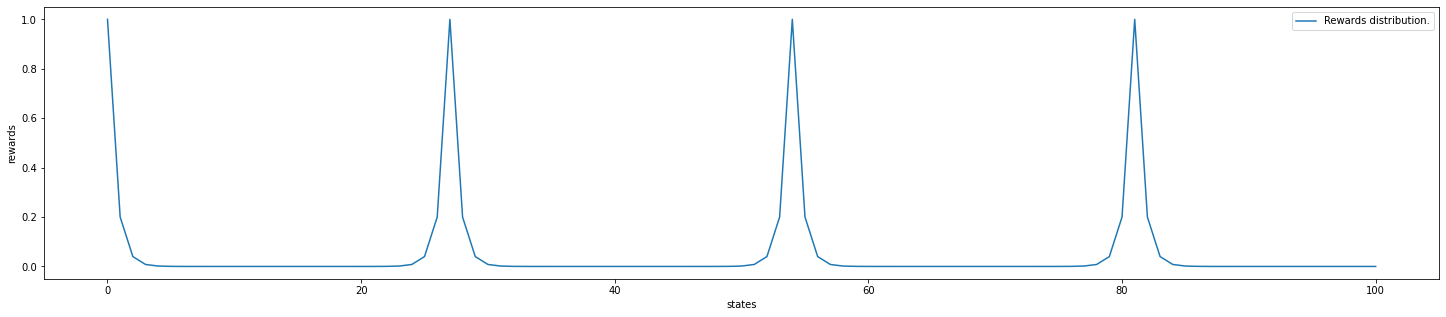

In [3]:
X = list(range(100+1))
R = [reward_function(x, a=27, lambda_ = 5) for x in X]

figsize=(25,5)
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize = figsize)

ax1.plot(X, R, label="Rewards distribution.")
ax1.set(xlabel='states', ylabel='rewards')
ax1.legend()

**2. MCMC :  Gibbs sampling and Metropolis-adjusted Langevin**

**TODO**

See [7] for the moment. I will describe the method and prove that it works later.

**3. Inverse Transform Sampling, Acceptance-Rejection Method and Important Sampling (wee need $\pi$)**



If we have a distribution of cumulative function $F : \mathbb{R} \to [0, 1]$ (assuming continuous) and $U ∼ \mathcal{U}([0, 1])$, then for all $x \in \mathbb{R}$ : $Pr\{F^{-1}(U) \le x\} = Pr\{U \le F(x)\} = F(x) \mbox{ since } F(x) \in [0, 1]$ $\Rightarrow$ The random variable $F^{-1}(U)$ is distributed as $F$.

So to generate a number that follows the probability distribution of cumulative function $F$, we can generate $u ∼ \mathcal{U}([0, 1])$ (we suppose that we have a random number generator that can do this), then return $F^{-1}(u)$ : this is how Inverse Transform Sampling works. If $F$ is not continuous, the proof must be re-write differently, but the method remains valid.






In rejection sampling, another density $q$ is considered from which we can sample directly and easily (e.g., inverse transform
method or whatever) under the restriction that $\pi = p \le Mq$ where $M > 0$ is an appropriate bound on $\frac{p}{q}$, $sup_{x} \frac{p(x)}{q(x)} \le M$. The easiest way to satisfy this assumption is to make sure that $q$ has heavier tails than $p$, and set $M = sup_{x \in support(p)} \frac{p(x)}{q(x)} \ (\mbox{assume } < \infty )$. We must ensure that the support of  $p$ is a subset of the support of $q$.

Then we can sample from $q$ directly and then reject the samples in a strategic way to make the resulting non-rejected samples look like they came from $p$.

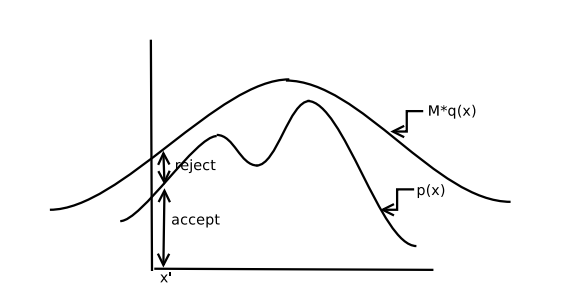

Figure from [8]

Algorithm :

i. Generate $u  ∼ \mathcal{U}([0, 1])$

ii. Generate a candidate $x ∼ q$ from the candidate density

iii. $\left\{
    \begin{array}{ll}
        & \mbox{Accept the candidate } x \mbox{ if } u < \frac{p(x)}{M \ q(x)} \\
        & \mbox{Otherwise, reject }  x \mbox{ and go back to the beginning (i)}
    \end{array}
\right.$



Let $X$ be the random varibal with density function $q$. We want to show that the conditional distribution of $X$ given that $u ∼ \mathcal{U}([0, 1]) < \frac{p(X)}{M \ q(X)}$ is $p$, ie $$Pr\bigg\{ X=x \ | \ u ∼ \mathcal{U}([0, 1]) < \frac{p(X)}{M \ q(X)} \bigg\} = p(x)$$

We recall that we need to choose the alternative probability distribution $q$ from which we already have an efficient algorithm for generating from (e.g., inverse transform method or whatever), but also such that the function $q(x)$ is close to $p(x)$. In particular, we assume that the ratio $\frac{p(x)}{q(x)}$ is bounded by a constant $M > 0$, $sup_{x} \frac{p(x)}{q(x)} \le M$ (and in practice we would want $M$ as close to 1 as possible).

The number of times $N$ that steps *i* and *ii* need to be called (the number of iterations needed to successfully generate a candidate) is itself a random variable and has a geometric distribution with success probability $$s = Pr\bigg\{ u ∼ \mathcal{U}([0, 1]) < \frac{p(X)}{M \ q(X)} \bigg\} = \int_{} F_{\mathcal{U}([0, 1]) \ | \ X = x} \bigg( \frac{p(X)}{M \ q(X)} \bigg) \ f_X\big(x\big) dx = \int_{} \frac{p(x)}{M \ q(x)} q(x) dx \mbox{ since } 0 < \frac{p(x)}{M \ q(x)} \le 1$$

$$\Rightarrow s = \int_{} \frac{p(x)}{M} dx = \frac{1}{M} \mbox{ (p is a density function, hence by definition integrates to 1)}$$ 

$N ∼ geometric(s) \Rightarrow Pr \{N = n\} = (1 − s)^{n−1} s, \ n \ge 1$. Thus on average the number of iterations required is given by $\mathbb{E}(N) = \frac{1}{s} = M$, the bounding constant, and we can now indeed see that it is desirable to choose our alternative density $q$ so as to minimize this constant $M=sup_{x} \frac{p(x)}{q(x)}$. Of course the optimal function would be $q(x) = p(x)$ which is not what we have in mind since the whole point is to choose a different (easy to simulate) alternative from $p$. In short, it is a bit of an art to find an appropriate $q$. In any case, we summarize with : **the expected number of iterations of the algorithm required until an X is successfully generated is exactly the bounding constant $M=sup_{x} \frac{p(x)}{q(x)}$**

Steps *i* ($u ∼ \mathcal{U}([0, 1])$) and *ii* ($x ∼ q$) being independent, we have :

$$Pr\bigg\{ X=x \ | \ u ∼ \mathcal{U}([0, 1]) < \frac{p(X)}{M \ q(X)} \bigg\} = \frac{Pr\bigg\{ X=x, u ∼ \mathcal{U}([0, 1]) < \frac{p(x)}{M \ q(x)} \bigg\}}{Pr\bigg\{ u ∼ \mathcal{U}([0, 1]) < \frac{p(X)}{M \ q(X)} \bigg\}} = M . f_X\big(x\big) .  Pr\bigg\{u ∼ \mathcal{U}([0, 1]) < \frac{p(x)}{M \ q(x)} \bigg\} = M . q(x) . \frac{p(x)}{M \ q(x)} = p(x) \ ▯ $$ 








---

4) GFlowNets



Before giving more details about GflowNets, let's first recall some concepts.

A directed graph is a tuple $(\mathcal{S}, \mathcal{A})$, where $\mathcal{S}$  is a set of states, and $\mathcal{A}$ a subset of $\mathcal{S} \times \mathcal{S}$ representing directed edges. Elements of $\mathcal{A}$ are denoted $s{\rightarrow}s'$ and called *edges* or *transitions*. 

For each element of $s \in \mathcal{S}$, we define two sets :  the set of its parents $Par(s) = \{ s' \ | \ s'{\rightarrow}s \in \mathcal{A} \}$ and the set of its children $Child(s) = \{ s' \ | \ s{\rightarrow}s' \in \mathcal{A} \}$.

A **trajectory** in such a graph is a sequence $\tau=(s_1, \dots, s_n)$ of elements of $\mathcal{S}$ such that every transition $s_t{\rightarrow}s_{t+1} \in \mathcal{A}$. 
* $s \in \tau$ means that $s$ is in the trajectory $\tau$, i.e., $\exists \text{ } t \in \{1,\dots, n\} \ / \ s_t=s$ 
* $s{\rightarrow}s' \in \tau$ means that $\exists t \in \{1, \dots, n\} \ / \ s_t=s,s_{t+1}=s'$.

A **directed acyclic graph** (DAG) is a directed graph in which there is no trajectory $\tau=(s_1, \dots, s_n)$ satisfying $s_n = s_1$, besides trajectories composed of one state only.

For the DAGs considered here, we have two special states :
* the *source/initial state* $s_0$, $Par(s_0) = \emptyset$ 
* the *sink/final state* $s_f$, $Child(s_f) = \emptyset$ 

Depending on the problem we can have many of these states. In this case, a special initial (resp. final) state can be created which is connected to all initial states (resp. to which all final states are connected). 

A trajectory that starts at $s_0$ and ends at $s_f$ is said to be complete. Hereafter, the complete trajectories $\tau=(s_0, s_1, \dots, s_n,s_f)$ will be noted simply $\tau=(s_0, s_1, \dots, s_n)$.


Let $\mathcal{X}$ be the set of final states, and let define on $\mathcal{X}$ a positive function $R$. The problem we want to solve is the following: how to define on $(\mathcal{S}, \mathcal{A})$ a generative model for which the probability $\pi(x)$ of generating an element $x \in \mathcal{X}$ is proportional to $R(x)$, ie $\pi(x)=\frac{R(x)}{\sum_{x \in \mathcal{X}}R(x)}$ ?

To achieve this, GflowNets define on the set of complete trajectories $\mathcal{T} = \{(s_0, \dots, s_n) | s_n \in \mathcal{X} \}$ a positive function $F$, called flow :
* which must respect the following condition, called reward matching condition: $R(x) = \sum_{\tau=(s_0, \dots, s_n) | s_n = x} F(\tau)$
* which must be Markovian, i.e. there must exist distributions $P_F(.|s)$ over the children $Child(s)$ of every non-terminal state $s$, and a constant $Z$, such that for any complete trajectory $\tau=(s_0, \dots, s_n)$ we have $P(\tau) = P_F(\tau) = P_F(s_n|s_{n-1}) P_F(s_{n-1}|s_{n-2}) \dots P_F(s_1|s_0) = \frac{F(\tau)}{Z}$. 

$Z$ is called the **total flow**, ie the sum of the flows of all the complete trajectories, $Z = \sum_{\tau \in \cal T} F(\tau)$. Note the equivalence between $Z$ and the partition function of a physical system as defined above : as in statistical physics, $Z$ captures how the rewards/probabilities are distributed among the different individual final states (or otherwise among the different complete trajectories).

$P_F(s_{t+1}|s_{t})$ is called a **forward policy**, and the authors of GflowNets have shown that by using it to construct a trajectory $\tau=(s_0, \dots, s_n)$, the probability that $s_n=x$ is proportional to $R(x)$.

We also have a **backwards transition probability** (given a terminal state $x \in \mathcal{X}$, $P_B$ can be used to sample a trajectory leading from $s_0$ to $x$). There must exist distributions $P_B(.|s)$ over the parent $Par(s)$ of every non-initial state $s$ such that for any terminal state $x$ we have : $$P(\tau=(s_0, \dots, s_n ) \ | \ s_n = x) = P_B(s_0|s_1) \dots P_B(s_{n-2}|s_{n-1}) P_B(s_{n-1}|s_n=x)$$

The **flow through a state** (or **state flow**) is the sum of the flows of the complete trajectories passing through that state, $F(s) = \sum_{\tau \in {\cal T}} 1_{s \in \tau} F(\tau)$.

The flow $F(s{\rightarrow}s')$ through an edge $s{\rightarrow}s'$ is called an **edge flow**. 

We then have :
* $F(s_0) = F(s_f) = \sum_{\tau\in \cal T} F(\tau) = Z$ because $\forall \tau \in \mathcal{T}$, $s_0 \in \tau$ and $s_f \in \tau$ 
* $P_F(s'|s) =\frac{F(s{\rightarrow}s')}{F(s)}$ (see the definition of $P_F(\tau)$ above)
* $P_B(s|s') = \frac{F(s{\rightarrow}s')}{F(s')}$
* In-flow for non-initial states : $F_{in}(s) = \sum_{s'' \in Par(s)} F(s''{\rightarrow}s)$ 
* Out-flow for non-terminal states : $F_{out}(s) = \sum_{s' \in Child(s)} F(s{\rightarrow}s')$ 

The objective in the following will be to generate the complete trajectories $\tau=(s_0, \dots, s_n = x)$ such that $F(s_t) = F_{in}(s_t) = F_{out}(s_t) \ \forall \ t \in {1, ...,n}$ and $F_{out}(s_0) = Z$, $F_{out}(s_n) = R(x)$.

If this objective is satisfied, we will have $\pi(x) =\frac{R(x)}{Z} \ \forall \ x \in \ \mathcal{X}$

---
**Flow matching objective**

A model $F_{\theta}(s, s')$ with learnable parameters $\theta$ approximates the edge flows $F(s{\rightarrow}s')$. The corresponding forward policy is given by $P_F(s'|s, \theta) = \frac{F_{\theta}(s, s')}{F(s)} = \frac{F_{\theta}(s, s')}{ \sum_{s'' \in Child(s)} F_{\theta}(s{\rightarrow}s'') }$. 

The parameters are trained to minimize the error in the flow matching constraint for all non-initial nodes $s$ :

$$ 
\mathcal{L}_{FM} \big(s\big) = \left\{
    \begin{array}{ll}
        \bigg( log \frac{ \sum_{s'' \rightarrow s} F_{\theta}(s'', s)}{R(s)} \bigg)^2 & \mbox{if } s \mbox{ terminal} \\
        \bigg( log \frac{ \sum_{s'' \rightarrow s} F_{\theta}(s'', s)}{ \sum_{s \rightarrow s'} F_{\theta}(s, s')} \bigg)^2 & \mbox{else.}
    \end{array}
\right. 
\\= \left\{
    \begin{array}{ll}
        \bigg[ log \bigg( \sum_{s'' \rightarrow s} F_{\theta}(s'', s) \bigg) - log \bigg( R(s) \bigg) \bigg]^2 & \mbox{if } s \mbox{ terminal} \\
        \bigg[ log \bigg( \sum_{s'' \rightarrow s} F_{\theta}(s'', s) \bigg) - log \bigg( \sum_{s \rightarrow s'} F_{\theta}(s, s') \bigg) \bigg]^2 & \mbox{else.}
    \end{array}
\right. 
$$

From a computational point of view, this loss is difficult to compute when $|Par(s)|$ is large, for many $s$, because it requires, being at a given non-initial state $s$, to enumerate all its parents, to evaluate the model $F_{\theta}$ on each of the parents, and to consider only the flows leading to $s$. 

This objective is optimized for nonterminal states $s$ and terminal states $x$ from trajectories sampled from a training policy $\pi_{\theta}$, a tempered (higher temperature) version of $P_F(.|s, \theta)$ which also helps exploration during training.
The parameters are updated with stochastic gradient $\mathbb{E}_{\tau=(s_0, \dots, s_n) \sim \pi_{\theta}} \nabla_{\theta} \bigg[ \sum_{t=1}^n \mathcal{L}_{FM} \big(s_t\big) \bigg]$

One issue from a learning point of view is that the flow will be very large for nodes near the root (early in the trajectory) and tiny for nodes near the leaves (late in the trajectory). In high-dimensional spaces the $F(s, .)$ and $F(s) = \sum_{.} F(s, .)$ for early states will be exponentially larger than for later states. Since we want $F(s, .)$ to be the output of a neural network, this would lead to serious numerical issues.

To avoid this problem, [1] define the flow matching objective on a log-scale, where they match not the incoming and outgoing flows but their logarithms, and they train the predictor to estimate $F_{\theta}^{log}(s, .) = logF(s, .)$, and exponentiate-sum-log the $F_{\theta}^{log}$ predictions to compute the loss, yielding the square of a difference of logs:
$$
\mathcal{L}_{FM} \big(s\big) = \left\{
    \begin{array}{ll}
        \bigg[ log \bigg( \epsilon + \sum_{s'' \rightarrow s} exp \text{ } F_{\theta}^{log}(s'', s) \bigg) - log \bigg( \epsilon + R(s) \bigg) \bigg]^2 & \mbox{if } s \mbox{ terminal} \\
        \bigg[ log \bigg( \epsilon + \sum_{s'' \rightarrow s} exp \text{ } F_{\theta} ^{log}(s'', s) \bigg) - log \bigg( \epsilon +  \sum_{s \rightarrow s'} exp \text{ } F_{\theta}^{log}(s, s') \bigg) \bigg]^2 & \mbox{else.}
    \end{array}
\right. 
$$

The hyper-parameter $\epsilon$ trades-off how much pressure we put on matching large versus small flows. We can set $\epsilon = min_{x \in \mathcal{X}} R(x)$.

We can also use this **Flow Matching** loss [2] :

$\mathcal{L}_{FM} \big(\tau = (s_0, ..., s_n = x) \big) = \bigg( log \bigg(  \frac{R(x)}{F_{\theta}(x)} \bigg)  \bigg)^2$

---
**Detailed balance objective**

$P_F(s'|s) =\frac{F(s{\rightarrow}s')}{F(s)}$ and $P_B(s|s') = \frac{F(s{\rightarrow}s')}{F(s')}$ $\Longrightarrow$ $F(s)P_F(s'|s) = F(s')P_B(s|s')$

This is called the detailed balance constraint. It is a bit similar to the reversibility condition of Markov chains.

A neural network model with parameters $\theta$ has input $s$ and three kinds of outputs: an estimated state flow $F_{\theta}(s)$, an estimated distribution over children $P_B(.|s, \theta)$, and an estimated distribution over parents $P_F(.|s, \theta)$. The error in the detailed balance constraint is optimized on actions $s{\rightarrow}s'$ between nodes seen along trajectories.

$$ 
\mathcal{L}_{DB} \big(s, s' \big) = \left\{
    \begin{array}{ll}
        \bigg( log \frac{F_{\theta}(s) P_{F} (s' | s; \theta)}{R(s') P_{B} (s | s'; \theta) } \bigg)^2 & \mbox{if } s' \mbox{ terminal} \\
        \bigg( log \frac{F_{\theta}(s) P_{F} (s' | s; \theta) }{F_{\theta}(s') P_{B} (s | s'; \theta) } \bigg)^2 & \mbox{else.}
    \end{array}
\right. 
\\= \left\{
    \begin{array}{ll}
        \bigg[ log(F_{\theta} (s)) - log\big( P_{B} (s' | s; \theta)\big) + log\big(P_{F} (s | s'; \theta)\big) - log(R(s'))  \bigg]^2 & \mbox{if } s' \mbox{ terminal} \\
        \bigg[ log(F_{\theta} (s)) - log(F_{\theta} (s')) - log\big( P_{B} (s' | s; \theta)\big) + log\big(P_{F} (s | s'; \theta)\big) \bigg]^2 & \mbox{else.}
    \end{array}
\right. 
$$

Similarly to flow matching, the parameters are updated with stochastic gradient
$\mathbb{E}_{\tau=(s_0, \dots, s_n) \sim \pi_{\theta}} \nabla_{\theta} \bigg[ \sum_{t=1}^n \mathcal{L}_{DB} \big(s_{t-1}, s_t\big) \bigg]$

---
**Trajectory Balance objective**

For any terminal state $x$ we have :

$$\prod_{t=1}^{n} P_B(s_{t-1}|s_t) = P(\tau=(s_0, \dots, s_n ) \ | \ s_n = x)  = \frac{P(\tau=(s_0, \dots, s_n=x))}{P(s_n=x)} = \frac{\prod_{t=1}^{n} P_F(s_t|s_{t-1})}{\frac{F(x)}{Z}}$$

This gives the trajectory balance constraint for any complete trajectory $\tau = (s_0, ..., s_n = x)$ : $$Z \prod_{t=1}^{n} P_F(s_t|s_{t-1}) = F(x) \prod_{t=1}^{n} P_B(s_{t-1}|s_t), \ Z = F(s_0), \ F(x) = R(x)$$

A model with parameters $\theta$ outputs estimated forward policy $P_F(.|s, \theta)$ and backward policy $P_B(.|s, \theta)$ for states $s$ (just as for detailed balance above), as well as a global scalar $Z_{\theta}$ estimating $F(s_0)$.

For a trajectory $\tau = (s_0, ..., s_n = x)$, [3] defines the trajectory loss ($F(x)$ is replaced by $R(x)$ because we want the two quantities to be equal) :

$$ 
\mathcal{L}_{TB} \big(\tau = (s_0, ..., s_n = x) \big) = \bigg( log \frac{Z_{\theta} \prod_{t=1}^{n} P_{F} (s_t | s_{t-1}; \theta) }{R(x) \prod_{t=1}^{n} P_{B} (s_{t-1} | s_t; \theta) } \bigg)^2
\\= \bigg[ log(Z_{\theta}) + \sum_{t=1}^{n} \bigg( - log\big( P_{B} (s_{t-1} | s_t; \theta)\big) + log\big(P_{F} (s_t | s_{t-1}; \theta)\big) \bigg) - log \big(R(x)\big) \bigg]^2
$$

The trajectory loss is updated along trajectories sampled from $\pi_{\theta}$, a tempered version of $P_F(.|., \theta)$, i.e., with stochastic gradient $\mathbb{E}_{\tau \sim \pi_{\theta}} \nabla_{\theta} \mathcal{L}_{TB} \big(\tau \big) $



---
More details : 
- https://milayb.notion.site/GFlowNet-Tutorial-919dcf0a0f0c4e978916a2f509938b00
- To go in depth: *GflowNets foundations* paper [2] (long, 70 pages) or *Trajectory Balance* paper [3] (very pedagogical paper).
- At the time of writing this tutorial, we have these papers on GflowNets : [1], [2], [3], [4], [5] and [6]

